# Creating Semi-synthetic data
This is the code to generate the semi-synthetic data to be used later in the model

date: May 23rd, 2025


In [1]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 
from scipy.signal import fftconvolve


In [2]:
# initlizing the parameters
H, W = 512, 512          # size of our world in pixels
CELL_SIZE = 30           # metres per pixel
lambda_precip  = 5000   # metres  
lambda_wetland = 10000  # metres
BETA0 = 50              # intercept in the outcome equation
BETA1_BASE = 1500.0         # baseline effect of wetland loss
BETA2, BETA3, BETA4 = 10.0, 0.0001, 0.0     # other coefficients
ALPHA = 0.3              # how strongly M_i modulates β₁
ETA0, ETA = -1.0, np.array([0.8,-0.003])  # for propensity score
DELTA = 1.2              # how much M_i drives treatment assignment
GAMMA = np.array([0.5, -0.2])            # how X modifies β₁
BETA5 = np.array([0.01,0.02])            # how X enters outcome additively
NOISE_SIGMA = 20.0       # Gaussian noise on Y

In [3]:
# --- logistic function for propensity score ---
def logistic(x):
    return 1/(1+np.exp(-x))

# --- random field generation function ---
def generate_grf(mean, std, corr):
    field = np.random.normal(mean, std, size=(H,W))
    return gaussian_filter(field, sigma=corr)

# --- hydrologic convolution function ---
def convolve_exp_fft(field, λ, cell_size, truncate=4):
    # build kernel as before
    R = int(truncate * λ / cell_size)
    y, x = np.ogrid[-R:R+1, -R:R+1]
    d = np.hypot(x, y) * cell_size
    K = np.exp(-d/λ)
    K /= K.sum()
    # FFT‐based convolution
    return fftconvolve(field, K, mode='same')

In [4]:
# Creating Base Rasters
dem    = generate_grf(200, 30, 15)   # elevation
precip = np.clip(generate_grf(10, 100, 10), 0.0, None)  # rainfall
imp    = np.clip(generate_grf(0.25,0.15,8), 0, 1)  # impervious frac.
pop    = np.exp(generate_grf(1.0,1.0,20))
pop    = (pop-pop.min())/(pop.max()-pop.min())     # M_i ∈ [0,1]

In [5]:
# Extra covariates
soil = np.clip(generate_grf(0.5,0.2,12),0,1)
dx,dy = np.gradient(dem)
slope = np.sqrt(dx**2 + dy**2)
X_stack = np.stack([soil, slope], axis=0)  # shape (2, H, W)

In [6]:
# Treatment assignment
X_flat = X_stack.reshape(2, -1)   # → (2, H*W)
M_flat = pop.reshape(-1)          # → (H*W,)
linpred = ETA0 + ETA.dot(X_flat) + DELTA*M_flat
p_flat = logistic(linpred)
T_flat = np.random.binomial(1, p_flat)
T = T_flat.reshape(H, W)
p = p_flat.reshape(H, W)


In [7]:
# Hydrologic convolution
KuP = convolve_exp_fft(precip,  lambda_precip,  CELL_SIZE)
KuT = convolve_exp_fft(T,       lambda_wetland, CELL_SIZE)

In [8]:
# Hetergoneity in treatment effect
beta1 = BETA1_BASE * (1 + ALPHA*pop + (GAMMA[:,None,None]*X_stack).sum(axis=0))
ITE   = beta1 * KuT

In [9]:
Y = (
    BETA0
  + ITE
  + BETA2 * KuP
  + BETA3 * dem
  + BETA4 * precip
  + (BETA5[:,None,None]*X_stack).sum(axis=0)
  + np.random.normal(0, NOISE_SIGMA, size=(H,W))
)

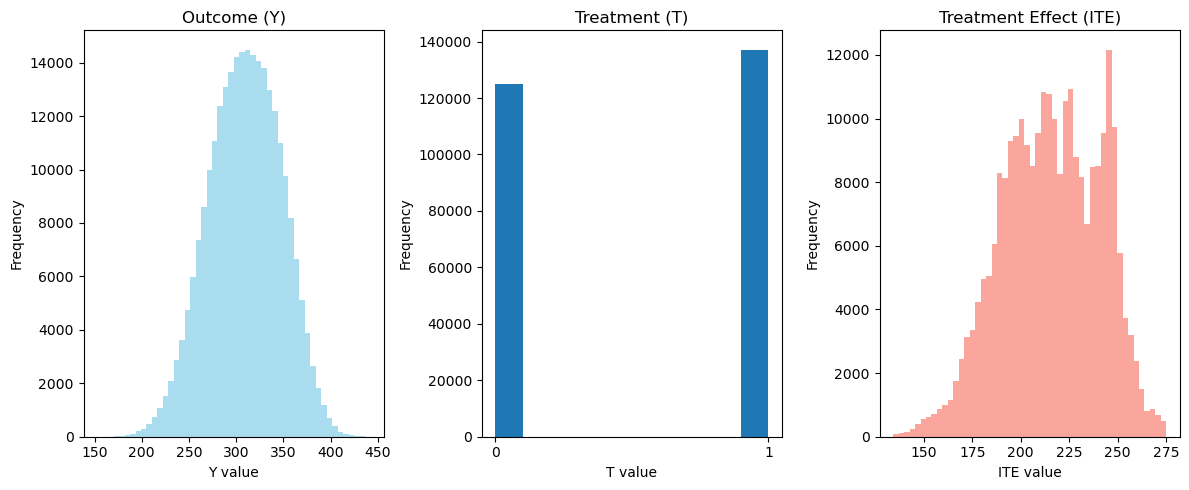

In [10]:
# Flatten for plotting
T_flat = T.ravel()
Y_flat = Y.ravel()

# Plot two separate histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Outcome histogram
axes[0].hist(Y_flat, bins=50, alpha=0.7, color='skyblue')
axes[0].set_title('Outcome (Y)')
axes[0].set_xlabel('Y value')
axes[0].set_ylabel('Frequency')

# Treatment histogram
axes[1].hist(T_flat)
axes[1].set_title('Treatment (T)')
axes[1].set_xlabel('T value')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])

# Treatment histogram
axes[2].hist(ITE.ravel(), bins=50, alpha=0.7, color='salmon')
axes[2].set_title('Treatment Effect (ITE)')
axes[2].set_xlabel('ITE value')
axes[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

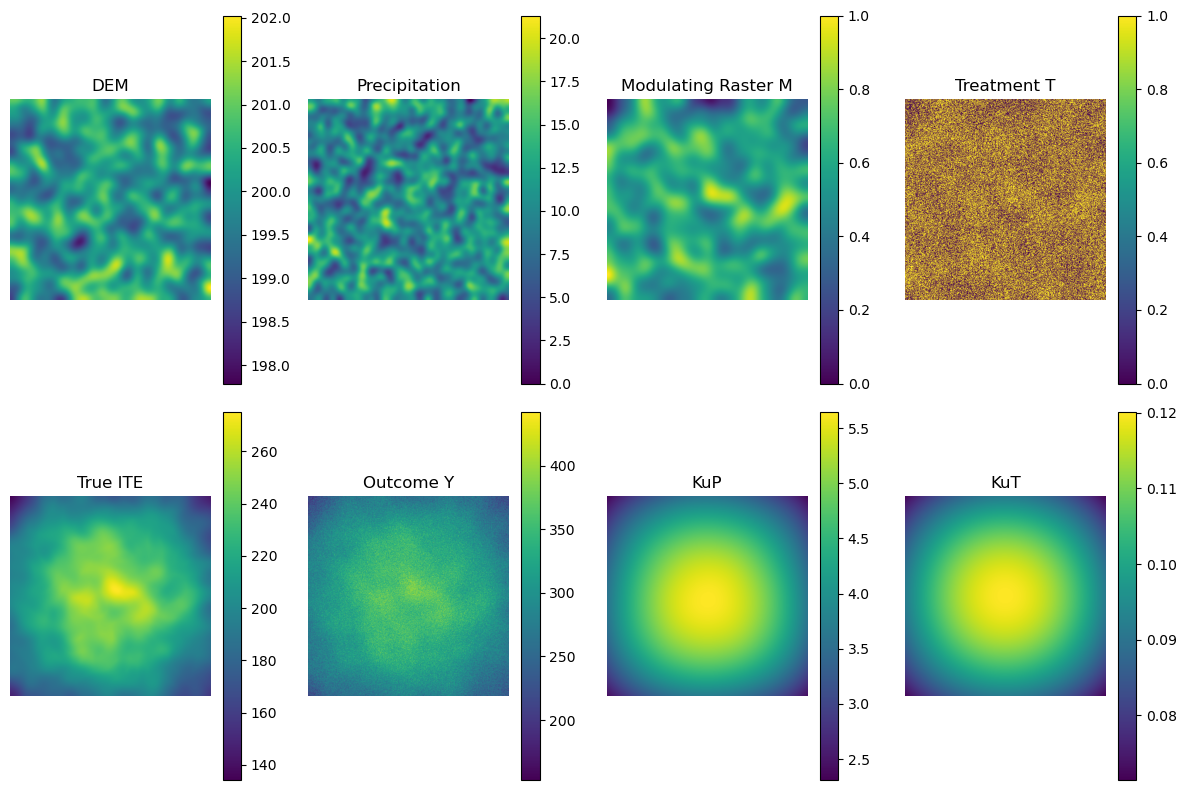

In [11]:
# Visualize the generated fields
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()
for ax, (arr, title) in zip(axes, [
    (dem, 'DEM'),
    (precip, 'Precipitation'),
    (pop, 'Modulating Raster M'),
    (T, 'Treatment T'),
    (ITE, 'True ITE'),
    (Y, 'Outcome Y'),
    (KuP, 'KuP'),
    (KuT, 'KuT')
]):
    im = ax.imshow(arr, cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [12]:
T = np.zeros((H, W))
sq = H//4
start = (H - sq)//2
T[start:start+sq, start:start+sq] = 1.0

In [13]:
# Hydrologic convolution
KuP = convolve_exp_fft(precip,  lambda_precip,  CELL_SIZE)
KuT = convolve_exp_fft(T,       lambda_wetland, CELL_SIZE)

In [14]:
# Hetergoneity in treatment effect
beta1 = BETA1_BASE * (1 + ALPHA*pop + (GAMMA[:,None,None]*X_stack).sum(axis=0))
ITE   = beta1 * KuT

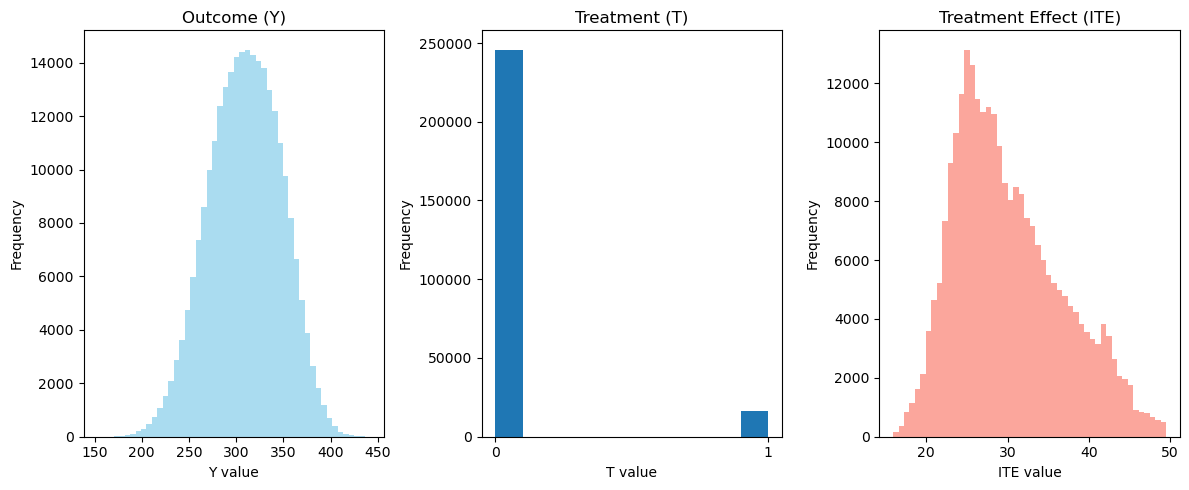

In [15]:
# Flatten for plotting
T_flat = T.ravel()
Y_flat = Y.ravel()

# Plot two separate histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Outcome histogram
axes[0].hist(Y_flat, bins=50, alpha=0.7, color='skyblue')
axes[0].set_title('Outcome (Y)')
axes[0].set_xlabel('Y value')
axes[0].set_ylabel('Frequency')

# Treatment histogram
axes[1].hist(T_flat)
axes[1].set_title('Treatment (T)')
axes[1].set_xlabel('T value')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])

# Treatment histogram
axes[2].hist(ITE.ravel(), bins=50, alpha=0.7, color='salmon')
axes[2].set_title('Treatment Effect (ITE)')
axes[2].set_xlabel('ITE value')
axes[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

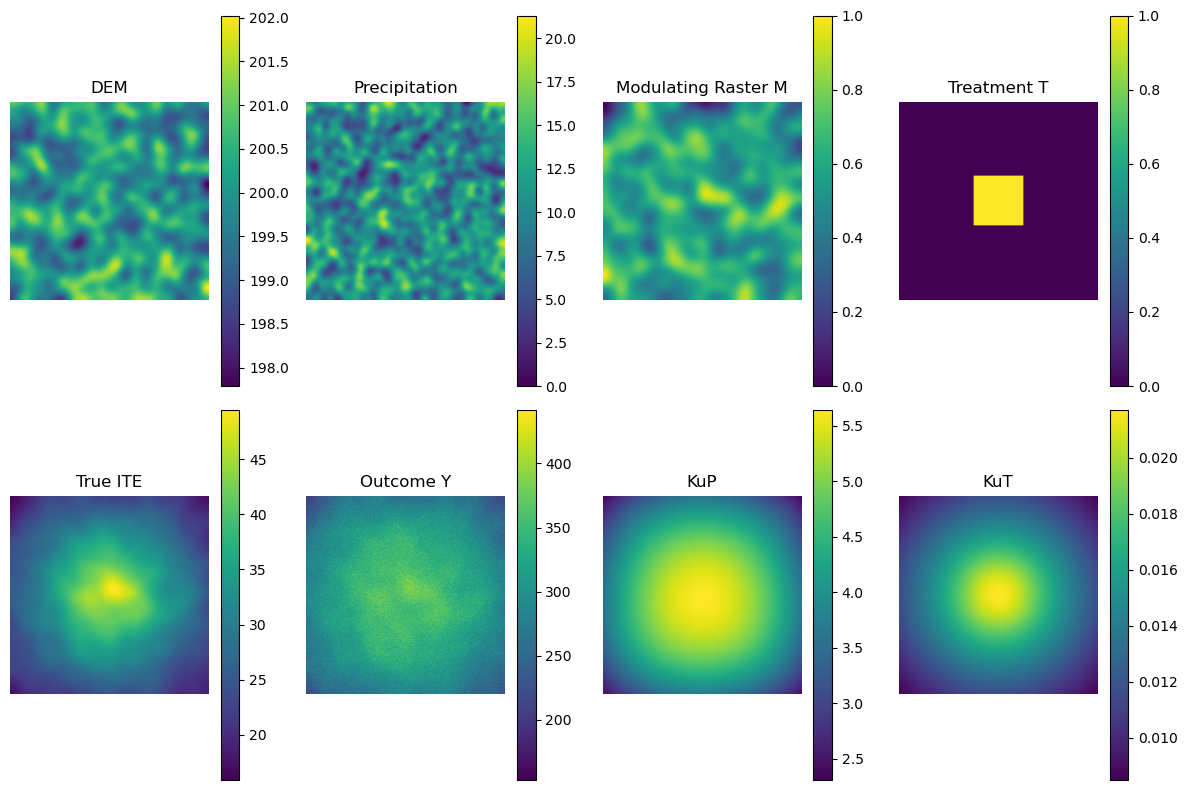

In [16]:
# Visualize the generated fields
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()
for ax, (arr, title) in zip(axes, [
    (dem, 'DEM'),
    (precip, 'Precipitation'),
    (pop, 'Modulating Raster M'),
    (T, 'Treatment T'),
    (ITE, 'True ITE'),
    (Y, 'Outcome Y'),
    (KuP, 'KuP'),
    (KuT, 'KuT')
]):
    im = ax.imshow(arr, cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()